


<h1 align=center> Financial Access Geospatial and Clustering Analysis using ArcGIS, DBSCAN & scikit-learn </h1>
<hr>



Geospatial mapping of all cash outlets in Tanzania in 2012. Cash outlets in this case included commercial banks, community banks, ATMs, microfinance institutions, mobile money agents, bus stations and post offices. This data was collected by FSDT. 

This dataset is supplemented with data from the FSDT Finscope 2017 survey that demographic information and what financial services are used by approximately 10,000 individuals across Tanzania.

By locating areas of high density that are separated from one another by areas of low density, this density-based clustering analysis aims to identify the group of access points which may represent clusters of individuals that remain excluded from financial products and institutions. 

Density, in this context, is defined as the number of points within a specified radius.  The advantage of using this procedure is that it finds different arbitrary shaped clusters without getting affected by noise.


Financial Access Point Census Tanzania
The Financial Sector Deepening Trust (FSDT) has completed the second round of the GIS Census of Financial
Access Points in Tanzania. This census maps and shows the proximity of basic cash in and cash out points
to where people live and transact. The availability of points where one can exchange cash for transferable or
storable electronic value is a key driver of financial access.
This data was collected by Brand Fusion Marketing Ltd following a competitive selection process done
in partnership with the Bank of Tanzania. The data collection was conducted between November 2013 and
March 2014

Financial Access Points: All physical locations around the country where one can conduct cash in and
cash out transactions.
Access Areas: Area within a given distance of any financial access point.

The Types of Financial Access Points Collected include:
1. Bank Infrastructure: branches of commercial banks, community banks, ATMs (standalone and at a
bank branch)
2. Microfinance Institutions
3. Mobile Money Agents of all Mobile Network Operators, both stand alone and shared agents
4. Point of Sales and Third Party Payment providers
5. SACCOS
6. Post Offices
7. Bus Stations 


In this section, the main focus will be manipulating the data and properties of DBSCAN and observing the resulting clustering.


Let's start playing with the data. We will be working according to the following workflow: </font>
- Loading data
- Overview data
- Data cleaning
- Data selection
- Clustering


Questions of interest

-
- distribution of access points by type
- distribution of access points by region
- shortest distance to access points
- shortest distance between access points
- largest customer share based on shortest distance
- largest customer share within 5 km radius
- 
-


In [1]:
import numpy as np 
import re
from sklearn.cluster import DBSCAN 
from sklearn.datasets import make_blobs 
from sklearn.preprocessing import StandardScaler 
import matplotlib.pyplot as plt 
%matplotlib inline
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

#GIS
from arcgis.gis import GIS
from arcgis.geocoding import geocode, reverse_geocode
from arcgis.geometry import Point
from geopy.distance import geodesic

gis = GIS("http://www.arcgis.com","chirpc","Sexzyp110890***")



In [2]:
import csv
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

##PATHS##
pth=r'C:\Users\SALDRU1\Dropbox\PC\Desktop\ml_lres\lab_wb_fin_incl\\'

##CANVAS VARIABLES##
s_bnk = "FSDT_FinAccessMapping\\banks_for_upload_win.csv"
s_atm = "FSDT_FinAccessMapping\\atm_for_upload_win.csv"
s_mfi = "FSDT_FinAccessMapping\\microfinance_for_upload_win.csv"
s_mom = "FSDT_FinAccessMapping\\mobilemoney_agents_for_upload_win.csv"
s_ppp = "FSDT_FinAccessMapping\\3rd_ppp_for_upload_win.csv"
s_scc = "FSDT_FinAccessMapping\\sacco_for_upload_win.csv"
s_bus = "FSDT_FinAccessMapping\\bus_stands_for_upload_win.csv"
s_pos = "FSDT_FinAccessMapping\\pos_for_upload_win.csv"
s_pst = "FSDT_FinAccessMapping\\post_office_for_upload_win.csv"

##

### DATA SOURCES

1. Financial Access Data

>The Financial Access Data is the geospatial mapping of all cash outlets in Tanzania in 2012. Cash outlets in this case included commercial banks, community banks, ATMs, microfinance institutions, mobile money agents, bus stations and post offices. This data was collected by FSDT.

2. Financial Inclusion Data

>The Financial Inclusion Data contains demographic information and what financial services are used by approximately 10,000 individuals across Tanzania. This data was extracted from the FSDT Finscope 2017 survey and prepared specifically for this challenge. More about the Finscope survey

3. National Statistics Data 

>The Population Data uses 2012 census data extracted from the "Administrative units Population Distribution Report" pulished on the Tanzania Bureau of Statistics website: https://www.nbs.go.tz/nbs/takwimu/Census2022/Administrative_units_Population_Distribution_Report_Tanzania_volume1a.pdf

>The GDP Data uses 2017 gdp per capita data extracted from the "National Accounts of Tanzania Mainland 2017" published on the Tanzania Bureau of Statistics website: https://www.nbs.go.tz/index.php/en/census-surveys/national-accounts-statistics/na-statistics-by-subject



#### Financial Access by Region


To determine financial access by region, we aggregate the number of financial access points across the various types of financial institutions and access points per region.


In [3]:
##merge financial access points files 

#Load mobile money financial access data and aggregate
v = "mobilemoney_agents_for_upload_win.csv"
df_acc = pd.read_csv(pth + "FSDT_FinAccessMapping\\" + v, encoding='latin1')
df_acc = df_acc[['region','district','ward','latitude','longitude']]
df_acc["type"] = "MoM"

##Count the number of financial access points per area##
#df_acc['no_MoM'] = 1
df_acc_agg = df_acc.groupby(['region']).size().reset_index(name='no_fin_acc')
df_acc_agg['perc_fin_acc'] = (df_acc_agg['no_fin_acc']/df_acc_agg['no_fin_acc'].sum())*100


#ward
df_acc_agg2 = df_acc.groupby(['region','district','ward']).size().reset_index(name='no_fin_acc_w')
df_acc_agg2['perc_fin_acc_w'] = (df_acc_agg2['no_fin_acc_w']/df_acc_agg2['no_fin_acc_w'].sum())*100


print("Name of file upload: ", v)
print("Dimensions (full): ", df_acc.shape)
print("Dimensions (aggregated): ", df_acc_agg.shape)

#for i in df_acc['region'].unique():
#    print(i)

#Create a master list for number of financial access points per area 

dict_files = {
"Bank": "banks_for_upload_win.csv", 
"ATM": "atm_for_upload_win.csv",
"MFI": "microfinance_for_upload_win.csv",
"PPP": "3rd_ppp_for_upload_win.csv", 
"Sacc": "sacco_for_upload_win.csv",
"Bus": "bus_stands_for_upload_win.csv",
"POS": "pos_for_upload_win.csv",
"Post": "post_office_for_upload_win.csv"   
}


#for x in list_path:	
for k,v in dict_files.items():
    #v = dict_files[x]
    #list_path.remove(x)
    
    print('----------------' + k + '----------------')
    print("Name of file upload: ", v)
    df = pd.read_csv(pth + "FSDT_FinAccessMapping\\" +  v, encoding='latin1')
    
    #Creat master list for financial access
    df = df[['region','district','ward','latitude','longitude']]
    df["type"] = k
    df_acc = pd.concat([df_acc,df])
    
    #Create aggregate list for the number of financial access point per ward
    #df = df[['region','district','ward','latitude','longitude']]   
    #df['no_'+k] = 1
    df_agg = df.groupby(['region']).size().reset_index(name='no_fin_acc')
    df_agg['perc_fin_acc'] = (df_agg['no_fin_acc']/df_agg['no_fin_acc'].sum())*100
    print("Dimensions: ", df_agg.shape)
    pd.concat([df_acc_agg,df_agg])
    
    #Ward level
    df_agg2 = df.groupby(['region','district','ward']).size().reset_index(name='no_fin_acc_w')
    df_agg2['perc_fin_acc_w'] = (df_agg2['no_fin_acc_w']/df_agg2['no_fin_acc_w'].sum())*100  
    #print("Dimensions: ", df_agg2.shape)
    pd.concat([df_acc_agg2,df_agg2])
    #df.to_csv(pth + v,  sep=",", encoding='utf-8',index=False)
    

print('\n----------------')
print("Financial access points master list (full): ", df_acc.shape)
print("Financial access points master list (aggregated): ", df_acc_agg.shape)
df_acc_agg.to_csv(pth + "fin_access_agg.csv", index=False)
df_acc.to_csv(pth + "fin_access.csv", index=False)
#df_acc.head()

C:\Users\SALDRU1\AppData\Local\Temp\ipykernel_28836\1133490666.py:5: DtypeWarning: Columns (26,32,33,42,74) have mixed types. Specify dtype option on import or set low_memory=False.
  df_acc = pd.read_csv(pth + "FSDT_FinAccessMapping\\" + v, encoding='latin1')


Name of file upload:  mobilemoney_agents_for_upload_win.csv
Dimensions (full):  (45429, 6)
Dimensions (aggregated):  (22, 3)
----------------Bank----------------
Name of file upload:  banks_for_upload_win.csv
Dimensions:  (22, 3)
----------------ATM----------------
Name of file upload:  atm_for_upload_win.csv
Dimensions:  (22, 3)
----------------MFI----------------
Name of file upload:  microfinance_for_upload_win.csv
Dimensions:  (21, 3)
----------------PPP----------------
Name of file upload:  3rd_ppp_for_upload_win.csv
Dimensions:  (21, 3)
----------------Sacc----------------
Name of file upload:  sacco_for_upload_win.csv
Dimensions:  (22, 3)
----------------Bus----------------
Name of file upload:  bus_stands_for_upload_win.csv
Dimensions:  (17, 3)
----------------POS----------------
Name of file upload:  pos_for_upload_win.csv
Dimensions:  (19, 3)
----------------Post----------------
Name of file upload:  post_office_for_upload_win.csv
Dimensions:  (22, 3)

----------------
Financ

In [4]:
print(df_acc.shape)
df_acc.head()

(56019, 6)


,region,district,ward,latitude,longitude,type
0,Ruvuma,Tunduru,Kalulu,-10.28298,40.18363,MoM
1,Ruvuma,Tunduru,Kalulu,-10.28457,40.18295,MoM
2,Kilimanjaro,Moshi Urban,Bondeni,-3.36025,37.33803,MoM
3,Dar es Salaam,Kinondoni,Manzese,-6.80213,39.22978,MoM
4,Kilimanjaro,Moshi Urban,Kiusa,-3.35613,37.33382,MoM


In [5]:
df_acc['region'].unique()

array(['Ruvuma', 'Kilimanjaro', 'Dar es Salaam', 'Mbeya', 'Arusha',
       'Pwani', 'Morogoro', 'Mwanza', 'Mara', 'Manyara', 'Iringa',
       'Tanga', 'Shinyanga', 'Singida', 'Tabora', 'Lindi', 'Kigoma',
       'Mtwara', 'Dodoma', nan, 'Rukwa', 'Kagera', 'Zanzibar'],
      dtype=object)

In [6]:
df_acc_agg['region'].unique()

array(['Arusha', 'Dar es Salaam', 'Dodoma', 'Iringa', 'Kagera', 'Kigoma',
       'Kilimanjaro', 'Lindi', 'Manyara', 'Mara', 'Mbeya', 'Morogoro',
       'Mtwara', 'Mwanza', 'Pwani', 'Rukwa', 'Ruvuma', 'Shinyanga',
       'Singida', 'Tabora', 'Tanga', 'Zanzibar'], dtype=object)

In [7]:
print(df_acc_agg.shape)
df_acc_agg.head()

(22, 3)


,region,no_fin_acc,perc_fin_acc
0,Arusha,3075,6.771785
1,Dar es Salaam,13687,30.141602
2,Dodoma,2212,4.871281
3,Iringa,2171,4.780991
4,Kagera,1642,3.616023


In [8]:
df_acc = pd.merge(df_acc, df_acc_agg, how='left', on=['region'])
df_acc = pd.merge(df_acc, df_acc_agg2, how='left', on=['region','district','ward'])
print(df_acc.shape)
df_acc.head()

(56019, 10)


,region,district,ward,latitude,longitude,type,no_fin_acc,perc_fin_acc,no_fin_acc_w,perc_fin_acc_w
0,Ruvuma,Tunduru,Kalulu,-10.28298,40.18363,MoM,755.0,1.662666,4.0,0.008809
1,Ruvuma,Tunduru,Kalulu,-10.28457,40.18295,MoM,755.0,1.662666,4.0,0.008809
2,Kilimanjaro,Moshi Urban,Bondeni,-3.36025,37.33803,MoM,2557.0,5.631042,141.0,0.310511
3,Dar es Salaam,Kinondoni,Manzese,-6.80213,39.22978,MoM,13687.0,30.141602,245.0,0.539541
4,Kilimanjaro,Moshi Urban,Kiusa,-3.35613,37.33382,MoM,2557.0,5.631042,76.0,0.167368


#### Financial Inclusion by Region

As described above, the financial inclusion data consists of demographic and financial service information. It also includes information on respondent's location based on approximate geospatial coordinates. While this is helpfulfor locating the respondents, we are also interested in knowing how accessible these financial services are based on a respondents distance from a particular institution. To do this, we need to determine the region of the respondent's location first before we can merge in the financial access points in that region. 

So in this step, we want to extract two features:

1. Regional location based on geospatial coordinates (using arcgis reverse coding method)
2. Nearest distance from financial access points based on geospatial coordinates (using a ball tree algorithm with the Haversine distance method in scikit-learn)



##### 1. Region of respondent location

In [9]:
#Prepare financial inclusion data
'''
# Below code extracts region based on coordinates using argis reverse geocoding method
df_inc = pd.read_csv(pth + "full.csv")
df_inc_loc = df_inc[['ID','Latitude','Longitude']]
df_inc_loc=df_inc_loc.rename(columns = {'Latitude':'lat1','Longitude':'lon1'})

#Check if data has any nulls
drop_col = []
for i in df_inc_loc.columns:
    perc_na = df_inc_loc[i].isna().sum()/len(df)*100
    if perc_na > 0:
        print(i)
    #no null values dectected detected

reg_lst = []
#Use argis module to find region of geolocation
for i in df_inc_loc.index:
    x = df_inc_loc.iloc[i]['lat1']
    y = df_inc_loc.iloc[i]['lon1']
    #print(x,y)
    
    unknown_pt = Point({"x":y,"y":x})
    #print(unknown_pt)
    address = reverse_geocode(location=unknown_pt)
    #print(address['address']['Region'])
    reg_lst.append(address['address']['Region'])
    #df_inc_loc.iloc[i]['Region'] = address['address']['Region']
df_inc_loc['region'] = reg_lst

df_inc_loc.head()
df_inc_loc.to_csv(pth + "region.csv", index=False)

#import pickle
#pickle_obj = pickle.dumps(df_inc_loc)
#df_inc_loc = pickle.loads(pickle_obj)

'''
#df_inc_loc = pd.read_csv(pth + "region.csv", index=False)
#df_inc_loc.shape
df_inc_loc = pd.read_csv(pth + "region.csv")
#df_acc_agg1 = df_acc_agg.groupby('region').sum()
df_inc_loc = pd.merge(df_inc_loc, df_acc_agg, how='left', on=['region'])
#df_inc_loc = df_inc_loc.iloc[:,1:]
print(df_inc_loc.shape)
df_inc_loc.head()


(9459, 6)


,ID,lat1,lon1,region,no_fin_acc,perc_fin_acc
0,5086,-4.460442,29.811396,Kigoma,1338.0,2.946552
1,1258,-6.176438,39.244871,Mjini Magharibi,NaN,NaN
2,331,-6.825702,37.652798,Morogoro,1441.0,3.173380
3,6729,-3.372049,35.808307,Arusha,3075.0,6.771785
4,8671,-7.179645,31.039095,Rukwa,551.0,1.213416


##### 2. Nearest distance from financial access point

To use a ball tree with the Haversine distance in scikit-learn, you must first convert the coordinates 
from degrees to radians.


In [10]:
#To calculate the nearest distance between respondent location and access point we use a ball tree 
#algorithm  with the Haversine distance in scikit-learn that leverages the power of priority queues.

#A ball tree is similar to a k-d tree except that instead of making partitions across a single dimension,
#it will divide points based on radial distances to a center. It handles higher dimensional data better 
#and will also permit the use of the Haversine metric.

df_acc_loc = df_acc
#print(df_acc_loc.shape)

df_acc_loc=df_acc_loc.rename(columns = {'latitude':'lat','longitude':'lon'})
df_inc_loc=df_inc_loc.rename(columns = {'lat1':'lat','lon1':'lon'})

#Drop any rows with missing latitude and longitude
df_inc_loc=df_inc_loc.dropna(subset=['lat','lon'])
print(df_inc_loc.shape)
df_acc_loc=df_acc_loc.dropna(subset=['lat','lon'])
print(df_acc_loc.shape)

#Creates new columns converting coordinate degrees to radians.
for column in df_inc_loc[["lat", "lon"]]:
    rad = np.deg2rad(df_inc_loc[column].values)
    df_inc_loc[f'{column}_rad'] = rad
for column in df_acc_loc[["lat", "lon"]]:
    rad = np.deg2rad(df_acc_loc[column].values)
    df_acc_loc[f'{column}_rad'] = rad

#print(df_inc_loc.info())

(9459, 6)
(56019, 10)


In [11]:

from faker import Faker
from sklearn.neighbors import BallTree
from geopy import distance

import functools
import time


# Timing Decorator
def timer(func):
    """Print the runtime of the decorated function"""
    @functools.wraps(func)
    def wrapper_timer(*args, **kwargs):
        start_time = time.perf_counter()    # 1
        value = func(*args, **kwargs)
        end_time = time.perf_counter()      # 2
        run_time = end_time - start_time    # 3
        print(f"Finished {func.__name__!r} in {run_time:.4f} secs")
        return value
    return wrapper_timer

def generate_balltree(df):
    '''
        Generate Balltree using customize distance (i.e. Geodesic distance)
    '''
    #return  BallTree(df[['lat', 'lon']].values, metric=lambda u, v: distance.distance(u, v).miles)
    # Takes the first group's latitude and longitude values to construct # the ball tree.
    ball = BallTree(df[["lat_rad", "lon_rad"]].values, metric='haversine')
    return ball

#@timer
def find_matches(tree, df):
    '''
        Find closest matches in df to items in tree
    '''
    # The amount of neighbors to return.
    k = 1
    earth_radius_in_kms = 6371
    # Executes a query with the second group. This will also return two
    # arrays.
    distances, indices = tree.query(df[["lat_rad", "lon_rad"]].values, k = k)   
    #distances, indices = tree.query(df[['lat', 'lon']].values, k = 1)        
    df['min_dist'] = distances * earth_radius_in_kms
    df['min_loc'] = indices  
    return df


def find_matches_2(tree, df):
    '''
        Find closest matches in df to items in tree
    '''

    ###########################################
    #The amount of neighbors to return.
    k = 2
    earth_radius_in_kms = 6371
    # Executes a query with the second group. This will also return two
    # arrays.
    distances, indices = tree.query(df[["lat_rad", "lon_rad"]].values, k = k)   
    min_dist = np.asanyarray([i[1] for i in distances])
    min_loc = np.asanyarray([i[1] for i in indices])
    df.loc[:,'min_dist'] = min_dist * earth_radius_in_kms
    df.loc[:,'min_loc'] = min_loc  
    return df
    #############################################
        

def find_matches_radius(tree, df, distance):
    distance_in_kms = distance
    earth_radius_in_kms = 6371
    r = distance_in_kms/earth_radius_in_kms
    count = tree.query_radius(df[["lat_rad", "lon_rad"]], r=r, count_only=True)
    #print(count)
    is_within,distances = tree.query_radius(df[["lat_rad", "lon_rad"]], r=r, count_only=False, return_distance=True)
    distances_in_km = distances*earth_radius_in_kms
    df['no_fin_acc_'+str(distance)+'km'] = count
    return df
    

Distance between customers and financial services

In [12]:

acc_lst = ["MoM", "Bank", "ATM", "MFI", "PPP", "Sacc", "Bus", "POS", "Post"]

##Full frame
df_tmp = df_acc_loc
try:
    df2 = df_inc_loc
    df1 = df_tmp
    tree = generate_balltree(df1)
    df=find_matches(tree, df2)
    for d in [5,30]:
        df=find_matches_radius(tree, df2, distance=d)
        df['perc_no_fin_acc_'+str(d)+'km'] = (df['no_fin_acc_'+str(d)+'km']/df_tmp.shape[0])*100  
    #dist_lst.append(df.to_dict('records'))
    df_loc = df
except Exception as e:    
    print(e)


df_loc=df_loc.sort_values(by='ID')
df_loc.head()

,ID,lat,lon,region,no_fin_acc,perc_fin_acc,lat_rad,lon_rad,min_dist,min_loc,no_fin_acc_5km,perc_no_fin_acc_5km,no_fin_acc_30km,perc_no_fin_acc_30km
3726,1,-6.785487,39.238824,Dar es Salaam,13687.0,30.141602,-0.118429,0.684847,0.173106,11151,6097,10.883807,20095,35.871758
412,2,-6.783983,39.239073,Dar es Salaam,13687.0,30.141602,-0.118403,0.684851,0.123616,51045,6035,10.773131,20076,35.837841
3521,3,-6.798815,39.248935,Dar es Salaam,13687.0,30.141602,-0.118662,0.685023,0.029349,14900,8410,15.012764,20076,35.837841
7026,4,-6.819875,39.238224,Dar es Salaam,13687.0,30.141602,-0.119029,0.684836,0.095868,6810,8111,14.479016,20086,35.855692
1314,5,-6.819884,39.238963,Dar es Salaam,13687.0,30.141602,-0.119029,0.684849,0.030045,6810,8141,14.532569,20086,35.855692


In [13]:
##By financial service
df_loc_long = pd.DataFrame(None, columns=df_inc_loc.columns)
dist_lst=[]
for i in acc_lst:
    df_tmp = df_acc_loc.loc[df_acc_loc['type']==i]
    #print(df_tmp.shape) 
    try:
        df2 = df_inc_loc
        df1 = df_tmp
        tree = generate_balltree(df1)
        df=find_matches(tree, df2)
        df['min_type'] = i
        #dist_lst.append(df.to_dict('records'))
        df_loc_long= pd.concat([df_loc_long,df])
        #print(df_acc_2_long.shape)
    except Exception as e:    
        print(e)
        
df_loc_long=df_loc_long.sort_values(by='ID')
df_loc_long.to_csv(pth + "fin_inc_dist_long.csv", sep=";", index=True)
df_loc_long.head()

,ID,lat,lon,region,no_fin_acc,perc_fin_acc,lat_rad,lon_rad,min_dist,min_loc,no_fin_acc_5km,perc_no_fin_acc_5km,no_fin_acc_30km,perc_no_fin_acc_30km,min_type
3726,1,-6.785487,39.238824,Dar es Salaam,13687.0,30.141602,-0.118429,0.684847,1.240991,5,6097,10.883807,20095,35.871758,MFI
3726,1,-6.785487,39.238824,Dar es Salaam,13687.0,30.141602,-0.118429,0.684847,1.124001,64,6097,10.883807,20095,35.871758,Post
3726,1,-6.785487,39.238824,Dar es Salaam,13687.0,30.141602,-0.118429,0.684847,1.194789,13,6097,10.883807,20095,35.871758,Bank
3726,1,-6.785487,39.238824,Dar es Salaam,13687.0,30.141602,-0.118429,0.684847,1.208682,887,6097,10.883807,20095,35.871758,Sacc
3726,1,-6.785487,39.238824,Dar es Salaam,13687.0,30.141602,-0.118429,0.684847,2.354794,2,6097,10.883807,20095,35.871758,Bus


Distance between financial services 

In [14]:
acc_lst = ["MoM", "Bank", "ATM", "MFI", "PPP", "Sacc", "Bus", "POS", "Post"]

##Full frame
distance = [5,30]
df_tmp1 = df_acc_loc
df_tmp2 = df_tmp1.copy()
try:
    df2 = df_tmp2
    df1 = df_tmp1
    tree = generate_balltree(df1)
    df=find_matches_2(tree, df2)
    for d in [5,30]:
        #print(d)
        df=find_matches_radius(tree, df2, distance=d)
        #df['no_fin_acc_rad'] = 
        df['perc_no_fin_acc_'+str(d)+'km'] = (df['no_fin_acc_'+str(d)+'km']/df_tmp1.shape[0])*100  
    #dist_lst.append(df.to_dict('records'))
    df_acc = df
#print(len(dist_lst))
except Exception as e:    
    print(e)
    
df_acc.head()

,region,district,ward,lat,lon,type,no_fin_acc,perc_fin_acc,no_fin_acc_w,perc_fin_acc_w,lat_rad,lon_rad,min_dist,min_loc,no_fin_acc_5km,perc_no_fin_acc_5km,no_fin_acc_30km,perc_no_fin_acc_30km
0,Ruvuma,Tunduru,Kalulu,-10.28298,40.18363,MoM,755.0,1.662666,4.0,0.008809,-0.179472,0.701337,0.041273,39395,288,0.514111,325,0.580160
1,Ruvuma,Tunduru,Kalulu,-10.28457,40.18295,MoM,755.0,1.662666,4.0,0.008809,-0.179500,0.701325,0.156324,39395,290,0.517682,325,0.580160
2,Kilimanjaro,Moshi Urban,Bondeni,-3.36025,37.33803,MoM,2557.0,5.631042,141.0,0.310511,-0.058647,0.651672,0.010052,49634,1404,2.506293,2195,3.918313
3,Dar es Salaam,Kinondoni,Manzese,-6.80213,39.22978,MoM,13687.0,30.141602,245.0,0.539541,-0.118720,0.684689,0.014055,39190,7453,13.304415,20099,35.878898
4,Kilimanjaro,Moshi Urban,Kiusa,-3.35613,37.33382,MoM,2557.0,5.631042,76.0,0.167368,-0.058576,0.651598,0.029573,24168,1398,2.495582,2204,3.934379


In [15]:
df_acc_long = pd.DataFrame(None, columns=df_acc_loc.columns)
dist_lst=[]
for i in acc_lst:
    df_tmp1 = df_acc_loc.loc[df_acc_loc['type']==i]
    #print(df_tmp1.shape)
    df_tmp2 = df_tmp1.copy()
    #print(df_tmp2.shape)   
    try:
        df2 = df_tmp2
        df1 = df_tmp1
        tree = generate_balltree(df1)
        df=find_matches_2(tree, df2)
        df['min_type'] = i
        #dist_lst.append(df.to_dict('records'))
        df_acc_long= pd.concat([df_acc_long,df])
        #print(df_acc_2_long.shape)
    except Exception as e:    
        print(e)

df_acc_long.to_csv(pth + "fin_acc_dist_long.csv", sep=";", index=True)
df_acc_long.head()

,region,district,ward,lat,lon,type,no_fin_acc,perc_fin_acc,no_fin_acc_w,perc_fin_acc_w,lat_rad,lon_rad,min_dist,min_loc,min_type
0,Ruvuma,Tunduru,Kalulu,-10.28298,40.18363,MoM,755.0,1.662666,4.0,0.008809,-0.179472,0.701337,0.041273,39395.0,MoM
1,Ruvuma,Tunduru,Kalulu,-10.28457,40.18295,MoM,755.0,1.662666,4.0,0.008809,-0.179500,0.701325,0.156324,39395.0,MoM
2,Kilimanjaro,Moshi Urban,Bondeni,-3.36025,37.33803,MoM,2557.0,5.631042,141.0,0.310511,-0.058647,0.651672,0.031796,19894.0,MoM
3,Dar es Salaam,Kinondoni,Manzese,-6.80213,39.22978,MoM,13687.0,30.141602,245.0,0.539541,-0.118720,0.684689,0.014055,39190.0,MoM
4,Kilimanjaro,Moshi Urban,Kiusa,-3.35613,37.33382,MoM,2557.0,5.631042,76.0,0.167368,-0.058576,0.651598,0.029573,24168.0,MoM


#### Population by Region

In [16]:
from tabula import read_pdf
import tabula

#Population - 2012 census
#url = "https://www.nbs.go.tz/nbs/takwimu/Census2022/Administrative_units_Population_Distribution_Report_Tanzania_volume1a.pdf"
pop ="Administrative_units_Population_Distribution_Report_Tanzania_volume1a.pdf"

try:
    df = tabula.read_pdf(pth + pop, pages=(31,32) )
    print(f"Found {len(df)} tables")
except Exception as e:
    print("Error {}".format(e))


#prepare dataframe
for i in df:
    i.drop(index=range(7), axis=0, inplace=True)
df_pop = pd.concat([df[0],df[1]])
df_pop = df_pop.iloc[:-1,0:2].rename(columns={"Unnamed: 0":"region", "Unnamed: 1":"pop_12"})
df_pop["pop_12"] = df_pop["pop_12"].map(lambda x: re.sub(",","",x))
#df_pop.reset_index(drop=True, inplace=True)

df_pop

Found 2 tables


,region,pop_12
7,Dodoma,2083588
8,Arusha,1694310
9,Kilimanjaro,1640087
10,Tanga,2045205
11,Morogoro,2218492
12,Pwani,1098668
13,Dar es Salaam,4364541
14,Lindi,864652
15,Mtwara,1270854
16,Ruvuma,1376891


#### GDP per Capita by Region

In [17]:
#GDP - Regional GDP per Capita at Current Market Prices,
gdp = "GDP\\National_Accounts_of_Tanzania_Manland_2015-2021.pdf"

try:
    df = tabula.read_pdf(pth + gdp, pages=57 , encoding='latin-1', relative_area=True, relative_columns=True)
    print(f"Found {len(df)} tables")
except Exception as e:
    print("Error {}".format(e))

#for each in df:
#    print(each)
    

#convert list to dataframe
df_gdp = pd.DataFrame(df[0])

df_gdp = df_gdp.iloc[:,0:2].drop(index=[0,1], axis=0)
df_gdp[['2015','2016','2017','2018']] = df_gdp['Unnamed: 0'].str.split(" ",expand=True)
df_gdp = df_gdp.iloc[:-1, [0,-2]].rename(columns={df_gdp.columns[0]:"region","2017":"gdp_17"})
#rt = lambda x: re.sub("(@[A-Za-z0–9]+)|([^-9A-Za-z \t])|(\w+:\/\/\S+)"," ",x)
df_gdp["gdp_17"] = df_gdp["gdp_17"].map(lambda x: re.sub(",","",x))
df_gdp["region"].loc[df_gdp["region"]=="Dar es salaam"] = "Dar es Salaam"
#df_gdp.reset_index(drop=True, inplace=True)
df_gdp



Found 1 tables


,region,gdp_17
2,Dodoma,1438016
3,Arusha,2859151
4,Kilimanjaro,2885925
5,Tanga,2432853
6,Morogoro,2252199
7,Pwani,1872708
8,Dar es Salaam,4095226
9,Lindi,2440764
10,Mtwara,2311244
11,Ruvuma,2923326


In [18]:
#Check if region columns match
region_lst = [x.lower() for x in set(df_acc['region'][(~df_acc['region'].isnull())])]
print(region_lst)

['mwanza', 'arusha', 'tanga', 'mara', 'manyara', 'kagera', 'iringa', 'kigoma', 'mtwara', 'dodoma', 'singida', 'mbeya', 'pwani', 'morogoro', 'lindi', 'zanzibar', 'dar es salaam', 'shinyanga', 'tabora', 'ruvuma', 'rukwa', 'kilimanjaro']


In [19]:
region_lst = [x.lower() for x in set(df_loc['region'][(~df_loc['region'].isnull())])]
print(region_lst)
print(df_pop[(~df_pop['region'].str.lower().isin(region_lst))])
#print("zanzibar" in (region_lst))
print(df_gdp[(~df_gdp['region'].str.lower().isin(region_lst))])
#print("zanzibar" in (region_lst))

['mwanza', 'arusha', 'kusini pemba', 'kusini unguja', 'tanga', 'manyara', 'mara', 'kagera', 'iringa', 'dodoma', 'mtwara', 'kigoma', 'geita', 'singida', 'mjini magharibi', 'mbeya', 'muchiga', 'pwani', 'morogoro', 'simiyu', 'lindi', 'kaskazini unguja', 'dar es salaam', 'kaskazini pemba', 'shinyanga', 'tabora', 'ruvuma', 'katavi', 'njombe', 'rukwa', 'kilimanjaro', 'songwe']
              region   pop_12
7  Tanzania Zanzibar  1303569
Empty DataFrame
Columns: [region, gdp_17]
Index: []


In [20]:
#share of customers to nearest financial access point
df_loc['no_cust_min_loc'] = df_loc.groupby(['min_loc'])['ID'].transform(len)
df_loc['perc_cust_min_loc'] = (df_loc['no_cust_min_loc']/df_loc['no_cust_min_loc'].count())*100  
df_loc.head()


,ID,lat,lon,region,no_fin_acc,perc_fin_acc,lat_rad,lon_rad,min_dist,min_loc,no_fin_acc_5km,perc_no_fin_acc_5km,no_fin_acc_30km,perc_no_fin_acc_30km,no_cust_min_loc,perc_cust_min_loc
3726,1,-6.785487,39.238824,Dar es Salaam,13687.0,30.141602,-0.118429,0.684847,0.173106,11151,6097,10.883807,20095,35.871758,2,0.021144
412,2,-6.783983,39.239073,Dar es Salaam,13687.0,30.141602,-0.118403,0.684851,0.123616,51045,6035,10.773131,20076,35.837841,4,0.042288
3521,3,-6.798815,39.248935,Dar es Salaam,13687.0,30.141602,-0.118662,0.685023,0.029349,14900,8410,15.012764,20076,35.837841,5,0.052860
7026,4,-6.819875,39.238224,Dar es Salaam,13687.0,30.141602,-0.119029,0.684836,0.095868,6810,8111,14.479016,20086,35.855692,6,0.063432
1314,5,-6.819884,39.238963,Dar es Salaam,13687.0,30.141602,-0.119029,0.684849,0.030045,6810,8141,14.532569,20086,35.855692,6,0.063432


In [21]:
##Financial Inclusion
#df_loc = df_loc[['ID','lat', 'lon', 'region', 'no_fin_acc', 'perc_fin_acc', 'lat_rad','lon_rad', 'min_dist_All', 'min_loc_All']].rename(columns={"min_dist_All":"min_dist", "min_loc_All":"min_loc"})
df_inc1 = pd.merge(df_loc, df_pop, how='left', on=['region'])
df_inc2 = pd.merge(df_inc1, df_gdp, how='left', on=['region'])
df_inc2=df_inc2.sort_values(by='ID')
df_inc2.to_csv(pth + "fin_incl_dist.csv", sep=";")
print(df_inc2.shape)
df_inc2.head()

(9459, 18)


,ID,lat,lon,region,no_fin_acc,perc_fin_acc,lat_rad,lon_rad,min_dist,min_loc,no_fin_acc_5km,perc_no_fin_acc_5km,no_fin_acc_30km,perc_no_fin_acc_30km,no_cust_min_loc,perc_cust_min_loc,pop_12,gdp_17
0,1,-6.785487,39.238824,Dar es Salaam,13687.0,30.141602,-0.118429,0.684847,0.173106,11151,6097,10.883807,20095,35.871758,2,0.021144,4364541,4095226
1,2,-6.783983,39.239073,Dar es Salaam,13687.0,30.141602,-0.118403,0.684851,0.123616,51045,6035,10.773131,20076,35.837841,4,0.042288,4364541,4095226
2,3,-6.798815,39.248935,Dar es Salaam,13687.0,30.141602,-0.118662,0.685023,0.029349,14900,8410,15.012764,20076,35.837841,5,0.052860,4364541,4095226
3,4,-6.819875,39.238224,Dar es Salaam,13687.0,30.141602,-0.119029,0.684836,0.095868,6810,8111,14.479016,20086,35.855692,6,0.063432,4364541,4095226
4,5,-6.819884,39.238963,Dar es Salaam,13687.0,30.141602,-0.119029,0.684849,0.030045,6810,8141,14.532569,20086,35.855692,6,0.063432,4364541,4095226


In [22]:
##Financial Access
df_acc1 = pd.merge(df_acc, df_pop, how='left', on='region')
df_acc2 = pd.merge(df_acc1, df_gdp, how='left', on='region')
#share of financial access point to population
df_acc2[['gdp_17','pop_12']] =df_acc2[['gdp_17','pop_12']].astype(float)
df_acc2['ratio_no_fin_pop'] = (df_acc2['no_fin_acc']/df_acc2['pop_12'])
df_acc2['no_fin_100000_ppl'] = (df_acc2['no_fin_acc']/df_acc2['pop_12'])*100000
df_acc2.to_csv(pth + "fin_acc_dist.csv", sep=";", index=True)
print(df_acc2.shape)
df_acc2.head()

(56019, 22)


,region,district,ward,lat,lon,type,no_fin_acc,perc_fin_acc,no_fin_acc_w,perc_fin_acc_w,...,min_dist,min_loc,no_fin_acc_5km,perc_no_fin_acc_5km,no_fin_acc_30km,perc_no_fin_acc_30km,pop_12,gdp_17,ratio_no_fin_pop,no_fin_100000_ppl
0,Ruvuma,Tunduru,Kalulu,-10.28298,40.18363,MoM,755.0,1.662666,4.0,0.008809,...,0.041273,39395,288,0.514111,325,0.580160,1376891.0,2923326.0,0.000548,54.833680
1,Ruvuma,Tunduru,Kalulu,-10.28457,40.18295,MoM,755.0,1.662666,4.0,0.008809,...,0.156324,39395,290,0.517682,325,0.580160,1376891.0,2923326.0,0.000548,54.833680
2,Kilimanjaro,Moshi Urban,Bondeni,-3.36025,37.33803,MoM,2557.0,5.631042,141.0,0.310511,...,0.010052,49634,1404,2.506293,2195,3.918313,1640087.0,2885925.0,0.001559,155.906364
3,Dar es Salaam,Kinondoni,Manzese,-6.80213,39.22978,MoM,13687.0,30.141602,245.0,0.539541,...,0.014055,39190,7453,13.304415,20099,35.878898,4364541.0,4095226.0,0.003136,313.595404
4,Kilimanjaro,Moshi Urban,Kiusa,-3.35613,37.33382,MoM,2557.0,5.631042,76.0,0.167368,...,0.029573,24168,1398,2.495582,2204,3.934379,1640087.0,2885925.0,0.001559,155.906364


### 4-Visualization
Visualization of stations on map using basemap package. The matplotlib basemap toolkit is a library for plotting 2D data on maps in Python. Basemap does not do any plotting on it’s own, but provides the facilities to transform coordinates to a map projections. 

Please notice that the size of each data points represents the average of maximum temperature for each station in a year. 


## Location of Financial Access Points

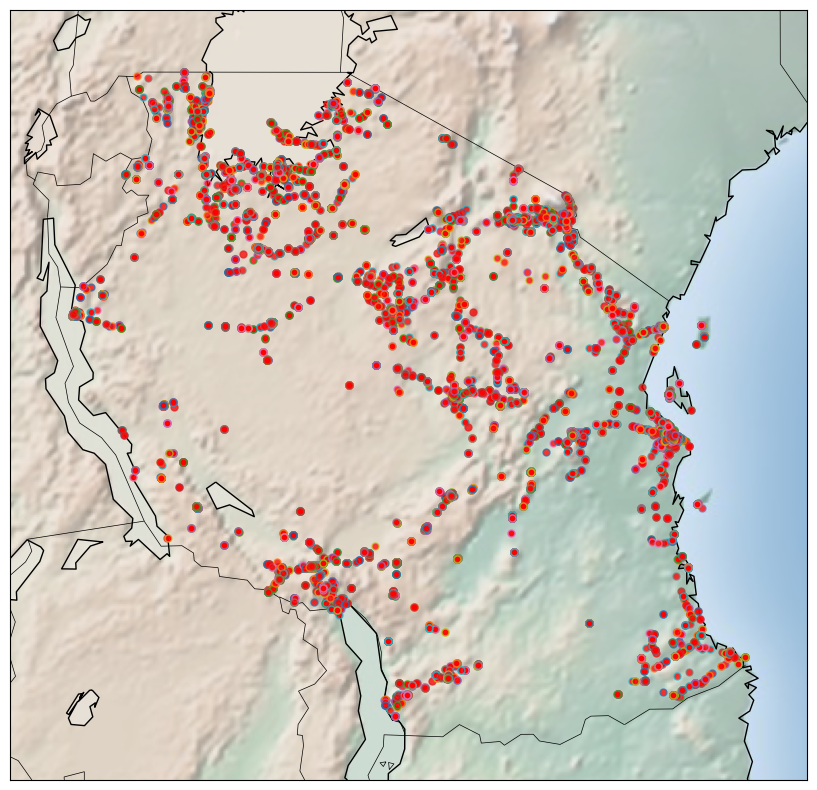

In [23]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline
rcParams['figure.figsize'] = (14,10)
#Subset dataset
#df_mom=df_mom.iloc[:,0:5]
df_loc=df_inc2
#col_lst = [("red","o"), ("blue","s"), ("yellow","^"), ("green","*"), ("orange","+"),("purple",">"), ("pink","<"), ("grey","d"),("brown",".")]

llon=np.min(df_acc['lon'])-1
ulon=np.max(df_acc['lon'])+1
llat=np.min(df_acc['lat'])-1
ulat=np.max(df_acc['lat'])+1

#pdf = pdf[(pdf['Long'] > llon) & (pdf['Long'] < ulon) & (pdf['Lat'] > llat) &(pdf['Lat'] < ulat)]

my_map = Basemap(projection='merc',
            resolution = 'l', area_thresh = 1000.0,
            llcrnrlon=llon, llcrnrlat=llat, #min longitude (llcrnrlon) and latitude (llcrnrlat)
            urcrnrlon=ulon, urcrnrlat=ulat) #max longitude (urcrnrlon) and latitude (urcrnrlat)

my_map.drawcoastlines()
my_map.drawcountries()
# my_map.drawmapboundary()
my_map.fillcontinents(color = 'white', alpha = 0.3)
my_map.shadedrelief()

# To collect data based on mobile money access points        

#acc
xs,ys = my_map(np.asarray(df_acc['lon']), np.asarray(df_acc['lat']))
df_acc['xm']= xs.tolist()
df_acc['ym'] =ys.tolist()


#Visualization1

for index,row in df_acc.iterrows():
    #   x,y = my_map(row.Long, row.Lat)
    #my_map.plot(row.xm, row.ym,markerfacecolor= v[0],  marker="o", markersize= 5, alpha = 0.75)
    my_map.plot(row.xm, row.ym,markerfacecolor =([1,0,0]),  marker='.', markersize= 10, alpha = 0.75)
    #plt.text(x,y,stn)
plt.show()



## Location of Respondents

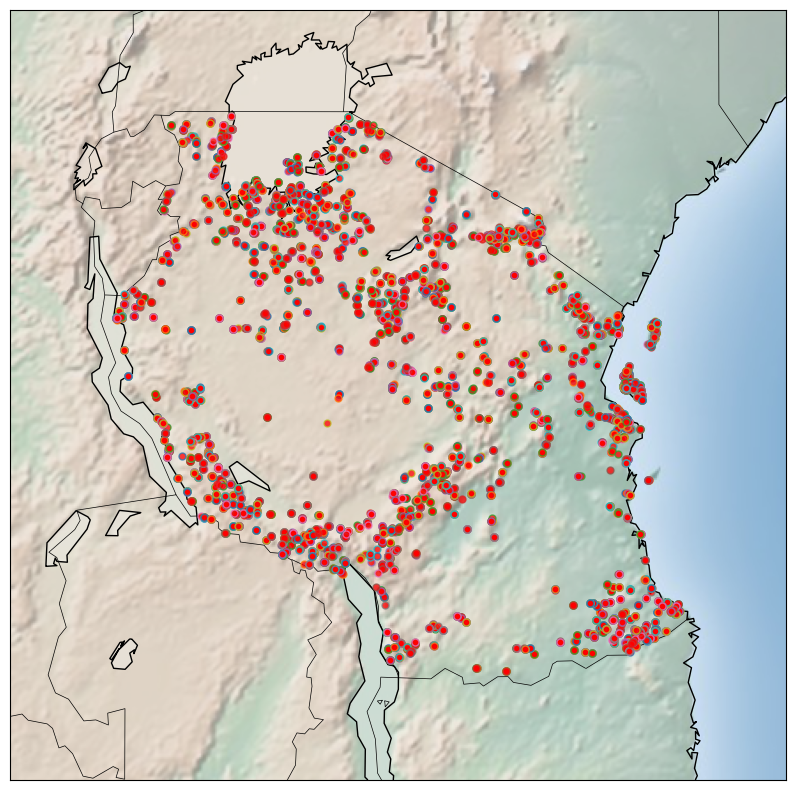

In [24]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline
rcParams['figure.figsize'] = (14,10)
#Subset dataset
#df_mom=df_mom.iloc[:,0:5]

acc_dict = {
    "MoM":["red","o"], 
    "Bank":["blue","s"], 
    "ATM":["yellow","^"], 
    "POS":["green","*"],  
    "MFI":["orange","+"], 
    "Sacc":["purple",">"], 
    "Post":["pink","<"], 
    "PPP":["grey","d"], 
    "Bus":["brown","."]
}
col_lst = ["red", "blue", "yellow", "green", "orange","purple", "pink", "grey","brown"]
#col_lst = [("red","o"), ("blue","s"), ("yellow","^"), ("green","*"), ("orange","+"),("purple",">"), ("pink","<"), ("grey","d"),("brown",".")]

llon=np.min(df_loc['lon'])-2
ulon=np.max(df_loc['lon'])+2
llat=np.min(df_loc['lat'])-2
ulat=np.max(df_loc['lat'])+2

#pdf = pdf[(pdf['Long'] > llon) & (pdf['Long'] < ulon) & (pdf['Lat'] > llat) &(pdf['Lat'] < ulat)]

my_map = Basemap(projection='merc',
            resolution = 'l', area_thresh = 1000.0,
            llcrnrlon=llon, llcrnrlat=llat, #min longitude (llcrnrlon) and latitude (llcrnrlat)
            urcrnrlon=ulon, urcrnrlat=ulat) #max longitude (urcrnrlon) and latitude (urcrnrlat)

my_map.drawcoastlines()
my_map.drawcountries()
# my_map.drawmapboundary()
my_map.fillcontinents(color = 'white', alpha = 0.3)
my_map.shadedrelief()

# To collect data based on mobile money access points        

#acc
xs,ys = my_map(np.asarray(df_loc['lon']), np.asarray(df_loc['lat']))
df_loc['xm']= xs.tolist()
df_loc['ym'] =ys.tolist()
#df_loc['col'] =loc_col


#Visualization1

for index,row in df_loc.iterrows():
    #   x,y = my_map(row.Long, row.Lat)
    #my_map.plot(row.xm, row.ym,markerfacecolor= v[0],  marker="o", markersize= 5, alpha = 0.75)
    my_map.plot(row.xm, row.ym,markerfacecolor =([1,0,0]),  marker='.', markersize= 10, alpha = 0.75)
    #plt.text(x,y,stn)
plt.show()



### 5- Clustering of stations based on their location i.e. Lat & Lon

__DBSCAN__ form sklearn library can run DBSCAN clustering from vector array or distance matrix. In our case, we pass it the Numpy array Clus_dataSet to find core samples of high density and expands clusters from them. 


In [25]:
from sklearn.cluster import DBSCAN
import sklearn.utils
from sklearn.preprocessing import StandardScaler
sklearn.utils.check_random_state(1000)
Clus_dataSet = df_loc[['xm','ym']]
Clus_dataSet = np.nan_to_num(Clus_dataSet)
Clus_dataSet = StandardScaler().fit_transform(Clus_dataSet)

# Compute DBSCAN
db = DBSCAN(eps=0.15, min_samples=10).fit(Clus_dataSet)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
df_loc["Clus_Db"]=labels

realClusterNum=len(set(labels)) - (1 if -1 in labels else 0)
clusterNum = len(set(labels)) 
print('Number of Clusters: ', clusterNum)

# A sample of clusters
df_loc['Clus_Db'].value_counts()
#set(labels)

Number of Clusters:  19


 0     5574
 1     2131
 3      820
 6      195
 2      171
 7      169
 4      120
-1       74
 12      44
 13      34
 5       29
 9       19
 15      19
 14      10
 16      10
 8       10
 11      10
 10      10
 17      10
Name: Clus_Db, dtype: int64

As you can see for outliers, the cluster label is -1


### 6- Visualization of clusters based on location
Now, we can visualize the clusters using basemap:


In [26]:
'''
#get color for min types
acc_dict = {
    "MoM":"red", 
    "Bank":"blue", 
    "ATM":"yellow", 
    "POS":"green",  
    "MFI":"orange", 
    "Sacc":"purple", 
    "Post":"pink", 
    "PPP":"grey", 
    "Bus":"brown"
}

loc_col = []
for i in df_loc['min_type'].to_list():
    for k, v in acc_dict.items():
        if k == i:
            loc_col.append(v)
            
df_loc['col'] = loc_col
df_loc=df_loc.sort_values(by='ID')
df_loc
'''
df_loc=df_loc.sort_values(by='ID')
df_loc

,ID,lat,lon,region,no_fin_acc,perc_fin_acc,lat_rad,lon_rad,min_dist,min_loc,...,perc_no_fin_acc_5km,no_fin_acc_30km,perc_no_fin_acc_30km,no_cust_min_loc,perc_cust_min_loc,pop_12,gdp_17,xm,ym,Clus_Db
0,1,-6.785487,39.238824,Dar es Salaam,13687.0,30.141602,-0.118429,0.684847,0.173106,11151,...,10.883807,20095,35.871758,2,0.021144,4364541,4095226,1.289777e+06,755286.232969,0
1,2,-6.783983,39.239073,Dar es Salaam,13687.0,30.141602,-0.118403,0.684851,0.123616,51045,...,10.773131,20076,35.837841,4,0.042288,4364541,4095226,1.289804e+06,755454.549816,0
2,3,-6.798815,39.248935,Dar es Salaam,13687.0,30.141602,-0.118662,0.685023,0.029349,14900,...,15.012764,20076,35.837841,5,0.052860,4364541,4095226,1.290901e+06,753793.740721,0
3,4,-6.819875,39.238224,Dar es Salaam,13687.0,30.141602,-0.119029,0.684836,0.095868,6810,...,14.479016,20086,35.855692,6,0.063432,4364541,4095226,1.289710e+06,751435.283823,0
4,5,-6.819884,39.238963,Dar es Salaam,13687.0,30.141602,-0.119029,0.684849,0.030045,6810,...,14.532569,20086,35.855692,6,0.063432,4364541,4095226,1.289792e+06,751434.303934,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9454,9455,-8.155919,39.279528,Pwani,1225.0,2.697703,-0.142348,0.685557,10.984789,2157,...,0.000000,28,0.049983,3,0.031716,1098668,1872708,1.294303e+06,601592.773873,12
9455,9456,-7.720054,38.938413,Pwani,1225.0,2.697703,-0.134740,0.679604,0.083388,6086,...,0.042843,59,0.105321,1,0.010572,1098668,1872708,1.256373e+06,650527.785186,0
9456,9457,-8.188564,39.314508,Pwani,1225.0,2.697703,-0.142917,0.686168,15.607184,30213,...,0.000000,28,0.049983,4,0.042288,1098668,1872708,1.298192e+06,597925.529255,12
9457,9458,-8.188592,39.314331,Pwani,1225.0,2.697703,-0.142918,0.686165,15.589683,30213,...,0.000000,28,0.049983,4,0.042288,1098668,1872708,1.298173e+06,597922.487082,12


Nearest Financial Access Point within Cluster 
-----------
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18


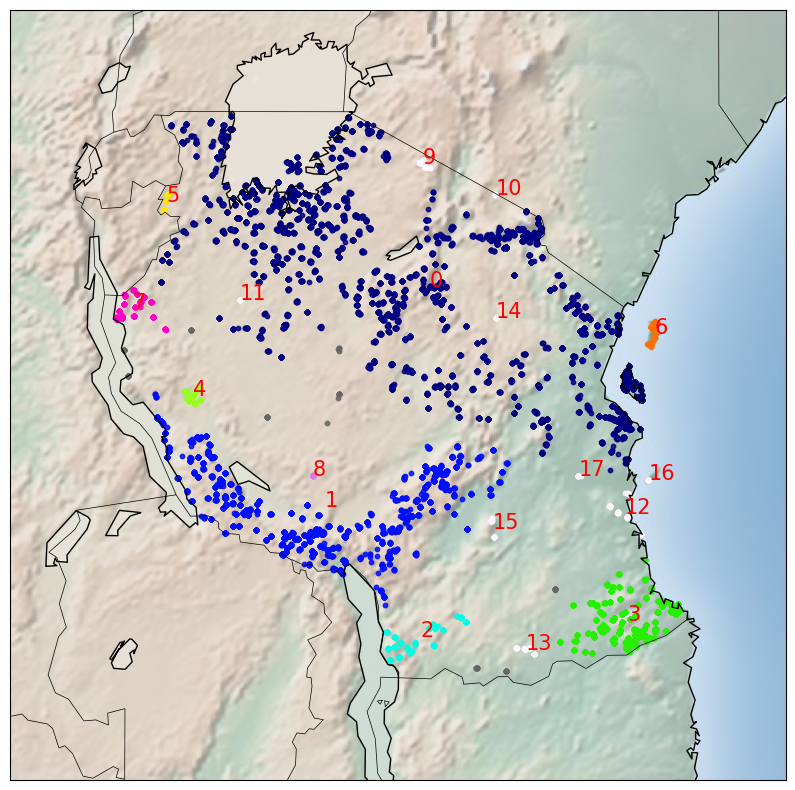

In [27]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline
rcParams['figure.figsize'] = (14,10)

my_map = Basemap(projection='merc',
            resolution = 'l', area_thresh = 1000.0,
            llcrnrlon=llon, llcrnrlat=llat, #min longitude (llcrnrlon) and latitude (llcrnrlat)
            urcrnrlon=ulon, urcrnrlat=ulat) #max longitude (urcrnrlon) and latitude (urcrnrlat)

my_map.drawcoastlines()
my_map.drawcountries()
#my_map.drawmapboundary()
my_map.fillcontinents(color = 'white', alpha = 0.3)
my_map.shadedrelief()

# To create a color map
colors = plt.get_cmap('gist_ncar')(np.linspace(0.0, 2.0, clusterNum))



#Visualization1
print('Nearest Financial Access Point within Cluster \n-----------')

for i,clust_number in enumerate(set(labels)):
    print(i)
    c=(([0.4,0.4,0.4]) if clust_number == -1 else colors[np.int(clust_number)])
    clust_set = df_loc[df_loc.Clus_Db == clust_number]                    
    my_map.scatter(clust_set.xm, clust_set.ym, color =c,  marker='o', s= 10, alpha = 0.85)
    if clust_number != -1:
        cenx=np.mean(clust_set.xm) 
        ceny=np.mean(clust_set.ym) 
        plt.text(cenx,ceny,str(clust_number), fontsize=15, color='red',)
        #print ('Cluster ' + str(clust_number)+': \n Nearest distance is '+ '%.4f' % np.min(clust_set.min_dist) + "km from " +  str(clust_set.loc[clust_set.min_dist==np.min(clust_set.min_dist)]['min_type'].values[0]) + " and an average distance of " + '%.4f' % np.mean(clust_set.min_dist) + "km \n")
        #if i < 3 :
        #    print(str(clust_set.loc[clust_set.min_dist==np.min(clust_set.min_dist)]['min_type'].iloc[i]))
        #    print ('Cluster ' + str(clust_set.iloc[i].Clus_Db)+': \n Nearest distance is '+ '%.4f' % np.min(clust_set.iloc[i].min_dist) + "km from " +  str(clust_set.loc[clust_set.min_dist==np.min(clust_set.min_dist)]['min_type'].iloc[i]) + " and an average distance of " + '%.4f' % np.mean(clust_set.iloc[i].min_dist) + "km \n")

### 7- Clustering of stations based on their location, gdp
In this section we re-run DBSCAN, but this time on a 5-dimensional dataset:


In [28]:
#Transformations
le = LabelEncoder()
#label_type = le.fit_transform(df_loc['min_type'])
#df_loc["min_type2"] = label_type
df_loc["lgdp_17"] = np.log(df_loc["gdp_17"].astype(float))
df_loc["lpop_12"] = np.log(df_loc["pop_12"].astype(float))
df_loc.head()

,ID,lat,lon,region,no_fin_acc,perc_fin_acc,lat_rad,lon_rad,min_dist,min_loc,...,perc_no_fin_acc_30km,no_cust_min_loc,perc_cust_min_loc,pop_12,gdp_17,xm,ym,Clus_Db,lgdp_17,lpop_12
0,1,-6.785487,39.238824,Dar es Salaam,13687.0,30.141602,-0.118429,0.684847,0.173106,11151,...,35.871758,2,0.021144,4364541,4095226,1.289777e+06,755286.232969,0,15.225332,15.289024
1,2,-6.783983,39.239073,Dar es Salaam,13687.0,30.141602,-0.118403,0.684851,0.123616,51045,...,35.837841,4,0.042288,4364541,4095226,1.289804e+06,755454.549816,0,15.225332,15.289024
2,3,-6.798815,39.248935,Dar es Salaam,13687.0,30.141602,-0.118662,0.685023,0.029349,14900,...,35.837841,5,0.052860,4364541,4095226,1.290901e+06,753793.740721,0,15.225332,15.289024
3,4,-6.819875,39.238224,Dar es Salaam,13687.0,30.141602,-0.119029,0.684836,0.095868,6810,...,35.855692,6,0.063432,4364541,4095226,1.289710e+06,751435.283823,0,15.225332,15.289024
4,5,-6.819884,39.238963,Dar es Salaam,13687.0,30.141602,-0.119029,0.684849,0.030045,6810,...,35.855692,6,0.063432,4364541,4095226,1.289792e+06,751434.303934,0,15.225332,15.289024


In [29]:
from sklearn.cluster import DBSCAN
import sklearn.utils
from sklearn.preprocessing import StandardScaler
sklearn.utils.check_random_state(1000)

Clus_dataSet = df_loc[['xm','ym','min_dist','lgdp_17']]
Clus_dataSet = np.nan_to_num(Clus_dataSet)
Clus_dataSet = StandardScaler().fit_transform(Clus_dataSet)

# Compute DBSCAN
db = DBSCAN(eps=0.3, min_samples=10).fit(Clus_dataSet)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
df_loc["Clus_Db"]=labels

realClusterNum=len(set(labels)) - (1 if -1 in labels else 0)
clusterNum = len(set(labels)) 
print('Number of Clusters: ', clusterNum)

# A sample of clusters
df_loc[["ID","region","min_dist","Clus_Db","gdp_17"]].head(5)

Number of Clusters:  41


,ID,region,min_dist,Clus_Db,gdp_17
0,1,Dar es Salaam,0.173106,0,4095226
1,2,Dar es Salaam,0.123616,0,4095226
2,3,Dar es Salaam,0.029349,0,4095226
3,4,Dar es Salaam,0.095868,0,4095226
4,5,Dar es Salaam,0.030045,0,4095226


### 8- Visualization of clusters based on location and gdp


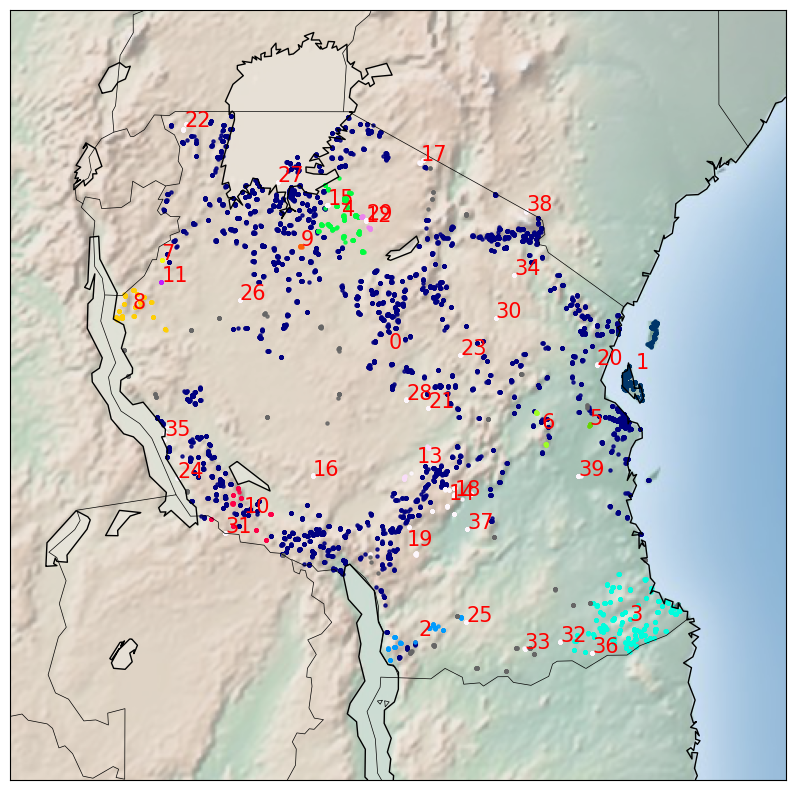

In [30]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline
rcParams['figure.figsize'] = (14,10)

my_map = Basemap(projection='merc',
            resolution = 'l', area_thresh = 1000.0,
            llcrnrlon=llon, llcrnrlat=llat, #min longitude (llcrnrlon) and latitude (llcrnrlat)
            urcrnrlon=ulon, urcrnrlat=ulat) #max longitude (urcrnrlon) and latitude (urcrnrlat)

my_map.drawcoastlines()
my_map.drawcountries()
#my_map.drawmapboundary()
my_map.fillcontinents(color = 'white', alpha = 0.3)
my_map.shadedrelief()

# To create a color map
colors = plt.get_cmap('gist_ncar')(np.linspace(0.0, 3.0, clusterNum))



#Visualization1
for clust_number in set(labels):
    c=(([0.4,0.4,0.4]) if clust_number == -1 else colors[np.int(clust_number)])
    clust_set = df_loc[df_loc.Clus_Db == clust_number]                    
    my_map.scatter(clust_set.xm, clust_set.ym, color =c,  marker='.', s= 20, alpha = 0.85)
    if clust_number != -1:
        cenx=np.mean(clust_set.xm) 
        ceny=np.mean(clust_set.ym) 
        plt.text(cenx,ceny,str(clust_number), fontsize=15, color='red',)
        
        #print ('Cluster ' + str(clust_number)+': \n Nearest distance is '+ '%.4f' % np.min(clust_set.min_dist) + "km from " +  str(clust_set.loc[clust_set.min_dist==np.min(clust_set.min_dist)]['min_type'].values[0]) + " and an average distance of " + '%.4f' % np.mean(clust_set.min_dist) + "km \n")